## Twitter Airline Sentiment Prediction

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

import missingno as msno

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from wordcloud import WordCloud
from string import punctuation
#from autocorrect import Speller



In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data Collection

In [3]:
df = pd.read_csv('https://github.com/mkhj/Data-science/raw/master/Natural%20Language%20Processing%20(NLP)/Data/Airline-Sentiment-2-w-AA.csv', sep= ',', header = [0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   _unit_id                      14640 non-null  int64  
 1   _golden                       14640 non-null  bool   
 2   _unit_state                   14640 non-null  object 
 3   _trusted_judgments            14640 non-null  int64  
 4   _last_judgment_at             14584 non-null  object 
 5   airline_sentiment             14640 non-null  object 
 6   airline_sentiment:confidence  14640 non-null  float64
 7   negativereason                9178 non-null   object 
 8   negativereason:confidence     10522 non-null  float64
 9   airline                       14640 non-null  object 
 10  airline_sentiment_gold        40 non-null     object 
 11  name                          14640 non-null  object 
 12  negativereason_gold           32 non-null     object 
 13  r

In [5]:
df.head(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/2015 05:24:40,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,570306133677760513,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/2015 01:53:36,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,570301130888122368,NaN,Pacific Time (US & Canada)


<Axes: >

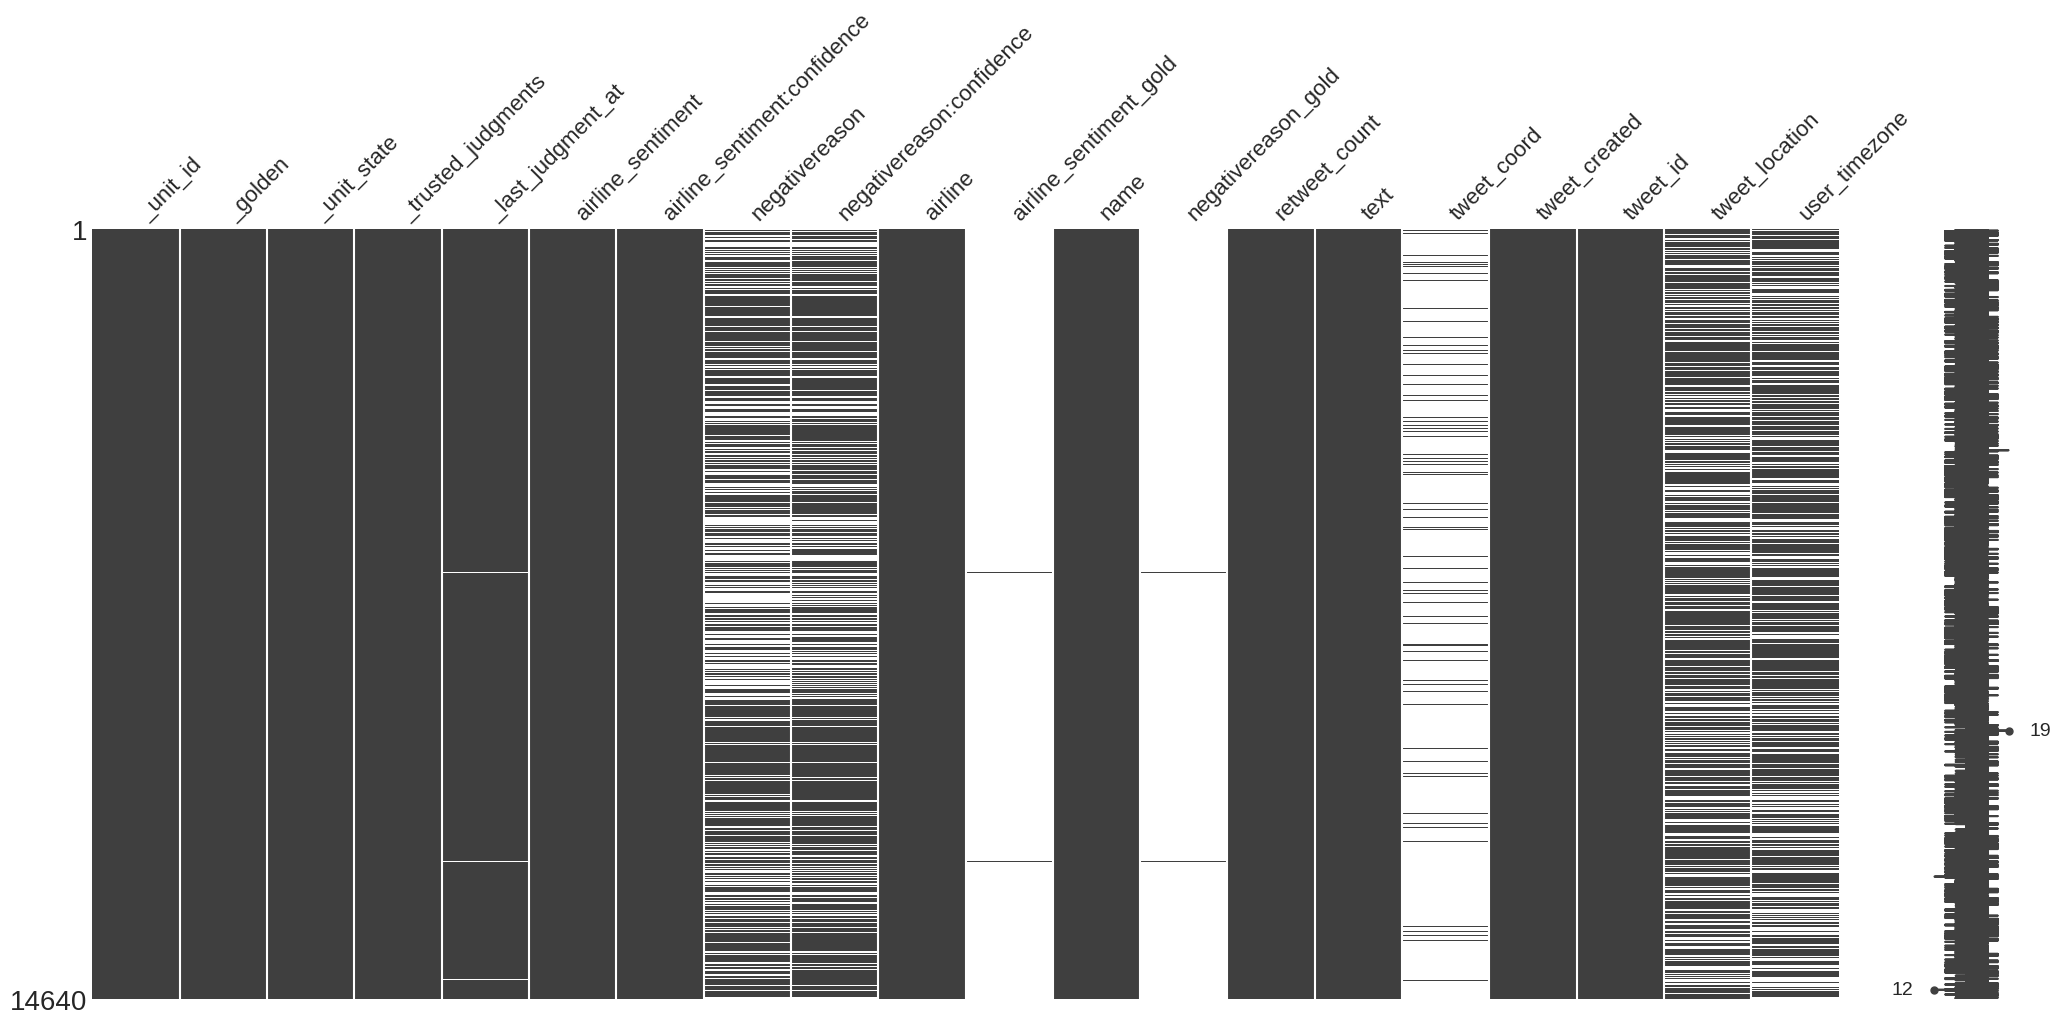

In [6]:
msno.matrix(df)


In [7]:
df = df.drop(df.columns.difference(['airline_sentiment','text']), axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


## Data Preprocesing & Cleaning

Text preprocessing steps include a few essential tasks to further clean the available text data. It includes tasks like:-

* **Stop-Word Removal** : In English words like a, an, the, as, in, on, etc. are considered as stop-words so according to our requirements we can remove them to reduce vocabulary size as these words don't have some specific meaning

* **Lower Casing** : Convert all words into the lower case because the upper or lower case may not make a difference for the problem. And we are reducing vocabulary size by doing so.

* **Stemming** : Stemming refers to the process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form (e.g., “walk” and “walking” are both reduced to “walk”).

* **Tokenization** : NLP software typically analyzes text by breaking it up into words (tokens) and sentences.

**PS:** The following code is not exhustive for how to clean code etc. A lot more can be done.

In [9]:
tweet_tokenizer = TweetTokenizer()
lemm = WordNetLemmatizer()

def remove_mentions(text):
  return re.sub(r'@\w+', '', text)

def remove_urls(text):
  return re.sub(r'http.?://[^\s]+[\s]?', '', text)

def only_characters(text):
  return re.sub('[^a-zA-Z\s]', '', text)

def remove_extra_spaces(text):
  text = re.sub("\s+", ' ', text)
  text = text.lstrip()
  return text.rstrip()

def to_lower(text):
  return text.lower()

def fix_words(text):
  text = re.sub(r'\bthx\b', 'thanks', text)
  text = re.sub(r'\bu\b', 'you', text)
  text = re.sub(r'\bhrs\b', 'hours', text)
  text = re.sub(r'\baa\b', 'a', text)
  text = re.sub(r'\bflightr\b', 'flight', text)
  text = re.sub(r'\bur\b', 'your', text)
  text = re.sub(r'\bhr\b', 'hour', text)
  text = re.sub(r'\bthru\b', 'through', text)
  text = re.sub(r'\br\b', 'are', text)
  text = re.sub(r'\bppl\b', 'people', text)
  text = re.sub(r'\btix\b', 'fix', text)
  text = re.sub(r'\bplz\b', 'please', text)
  text = re.sub(r'\bflightd\b', 'flighted', text)
  text = re.sub(r'\btmrw\b', 'tomorrow', text)
  text = re.sub(r'\bthx\b', 'thanks', text)
  text = re.sub(r'\bpls\b', 'please', text)
  text = re.sub(r'\bfyi\b', 'for your information', text)

  text = re.sub(r'\bheyyyy\b', 'hey', text)
  text = re.sub(r'\bguyyyys\b', 'guys', text)
  text = re.sub(r'\byall\b', 'you all', text)
  text = re.sub(r'\basap\b', 'as soon as possible', text)
  text = re.sub(r'\bbtw\b', 'by the way', text)
  text = re.sub(r'\bdm\b', 'direct message', text)
  text = re.sub(r'\bcudtomers\b', 'customers', text)
  text = re.sub(r'\bwtf\b', 'what the fuck', text)
  text = re.sub(r'\biphone\b', 'phone', text)
  text = re.sub(r'\bmins\b', 'minutes', text)
  text = re.sub(r'\btv\b', 'television', text)
  text = re.sub(r'\bokay\b', 'ok', text)
  text = re.sub(r'\bfeb\b', 'february', text)
  text = re.sub(r'\byr\b', 'year', text)
  text = re.sub(r'\bshes\b', 'she is', text)
  text = re.sub(r'\bnope\b', 'no', text)
  text = re.sub(r'\bhes\b', 'he is', text)
  text = re.sub(r'\btill\b', 'until', text)
  text = re.sub(r'\bomg\b', 'oh my god', text)
  text = re.sub(r'\btho\b', 'though', text)
  text = re.sub(r'\bnothappy\b', 'not happy', text)

  return re.sub(r'\bthankyou\b', 'thank you', text)

stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

def remove_stopwords(row):
    return [token for token in row if token not in stop]

def clean_text(text):

  cleaning_metods = [remove_mentions, remove_urls, only_characters, remove_extra_spaces, to_lower, fix_words]
  for fn in cleaning_metods:
    text = fn(text)

  tokens = tweet_tokenizer.tokenize(text)

  tokens = remove_stopwords(tokens)

  stemmed =[lemm.lemmatize(token) for token in tokens if token not in list(punctuation) and len(token)>2]
  stemmed_tokens = [token for token in stemmed if token.isalpha()]

  clean_text = ' '.join(stemmed_tokens)

  return clean_text

In [10]:
# remove all neutral tweets
# df = df[df['airline_sentiment']!='neutral']

In [11]:
df['clean_text'] = df['text'].apply(clean_text)


In [12]:
pd.set_option('display.max_colwidth', None)

df[['text', 'clean_text']].head(-10)

,text,clean_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus youve added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,didnt today must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment guest face little recourse
4,@VirginAmerica and it's a really big bad thing about it,really big bad thing
...,...,...
14625,@AmericanAir Flight 236 was great. Fantastic cabin crew. A+ landing. #thankyou #JFK http://t.co/dRW08djHAI,flight great fantastic cabin crew landing thank jfk
14626,@AmericanAir Flight 953 NYC-Buenos Aires has been delay since yesterday at 10PM. Is going to take off at 3.30PM now? Give us answers!,flight nycbuenos aire delay since yesterday going take give answer
14627,"@AmericanAir Flight Cancelled Flightled, can't go home until tomorrow. I could use dinner and a play, @AmericanAir! It's my first time in NYC.",flight cancelled flightled cant home tomorrow could use dinner play first time nyc
14628,"Thank you. “@AmericanAir: @jlhalldc Customer Relations will review your concerns and contact you back directly, John.”",thank customer relation review concern contact back directly john


## Sentiment Prediction with Vader

Checking the distribution of airline sentiments

In [13]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

**Implement VADER Sentiment Analysis**

In [14]:
sent_analyzer = SentimentIntensityAnalyzer() # vader

def format_output(output_dict):

    polarity = "neutral"

    if(output_dict['compound']>= 0.05):
        polarity = "positive"

    elif(output_dict['compound']<= -0.05):
        polarity = "negative"

    return polarity


def predict_sentiment(text):

    output_dict =  sent_analyzer.polarity_scores(text)
    return format_output(output_dict)


In [15]:
df["vader_prediction"] = df["clean_text"].apply(predict_sentiment)

In [16]:
df = df[['text', 'clean_text', 'airline_sentiment', 'vader_prediction']]

In [17]:
df.sample(5)

,text,clean_text,airline_sentiment,vader_prediction
7507,"@JetBlue Flight 1562 had a 4 1/2 hour weather delay, but what is the 45 minute delay in getting bags to tired passengers?",flight hour weather delay minute delay getting bag tired passenger,negative,negative
9628,@USAirways three hour wait and counting waiting for reservations on the phone. Are you serious!?,three hour wait counting waiting reservation phone serious,negative,negative
9813,"@USAirways we've been waiting at the gate for 2 hrs, why are we now waiting to stow the luggage?",weve waiting gate hour waiting stow luggage,negative,neutral
10714,@USAirways This is the last time I use your airline. I promise that!,last time use airline promise,negative,positive
11305,@USAirways is the real MVP for holding up the flight connecting Philly to Tampa.,real mvp holding flight connecting philly tampa,negative,neutral


### Inspect VADER Performance

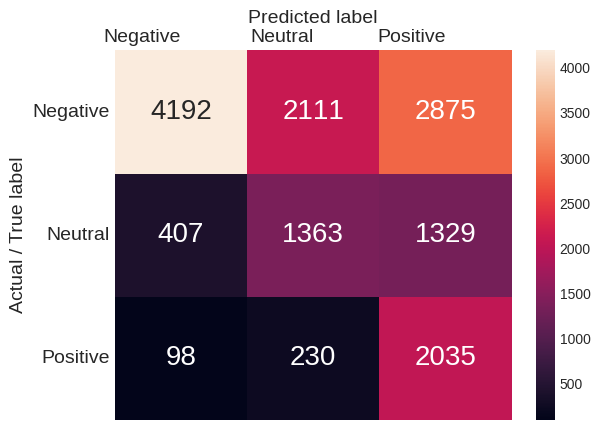

In [18]:
cfm = confusion_matrix(df['airline_sentiment'], df['vader_prediction'])
df_confusion_matrix = pd.DataFrame(cfm, ('Negative', 'Neutral', 'Positive'), ('Negative', 'Neutral', 'Positive'))

heatmap = sns.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 20}, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')

plt.ylabel('Actual / True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

plt.show()


##### **Accuracy**
This is the ratio of correctly predicted observations to the total observations.

$$
Accuracy = \frac{\ True Positive + True Negative}{Total Observations}
$$

In [19]:
accuracy = accuracy_score(df['airline_sentiment'], df['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

Accuracy: 0.5184426229508197



#### Classification report

##### **Precision**
This tells us how manny of the predicted positive events are positive
(e.g. when it predicts "A", how often is it correct?).

$$
Precision = \frac{\ True Positives}{True Positives + False Positives}
$$

##### **Recall** (aka sensitivity or true positive rate)
This tell us how many of the actual positive events are correctly predicted as positive (e.g. when it's actually "A", how often does it predict "A"?).

$$
Recall = \frac{\ True Positives}{True Positives + False Negatives}
$$

##### **F1-score**
A helpful metric for comparing two classifiers. F1 Score takes into account precision and the recall (a higher score equals a better model) and provides a balance between the two metrics.

$$
F1 = 2 \times \frac{\ Precision \times Recall}{Precision + Recall}
$$

##### **Support**
Support is the number of actual occurrences of the class in the specified dataset.

In [20]:
report = classification_report(df['airline_sentiment'], df['vader_prediction'])
print(report)

              precision    recall  f1-score   support

    negative       0.89      0.46      0.60      9178
     neutral       0.37      0.44      0.40      3099
    positive       0.33      0.86      0.47      2363

    accuracy                           0.52     14640
   macro avg       0.53      0.59      0.49     14640
weighted avg       0.69      0.52      0.54     14640



##### **Precision**
Out of all the tweets predicted as negative, 89% were actually negative

$$
Precision = \frac{\ 4192 }{4192 + 407 + 98} = 0.8924
$$

##### **Recall**:
Out of all the actual negative tweets, Vader correctly identified 45%

$$
Recall = \frac{\ 4192 }{4192 + 2111 + 2875} = 0.4567
$$

### Insights

With an accuracy of 51.8% the prediction is just as good as flipping a coin. More work on preparing the data could maybe be one way to improve the result.

## Sentiment Prediction with TextBlob

In [21]:
def format_textblog_output(output_dict):

    polarity = "neutral"

    if(output_dict.polarity >= 0.05):
        polarity = "positive"

    elif(output_dict.polarity <= -0.05):
        polarity = "negative"

    return polarity


def predict_textblot_sentiment(text):

    output_dict =  TextBlob(text).sentiment
    return format_textblog_output(output_dict)

In [22]:
df["textblob_prediction"] = df["clean_text"].apply(predict_textblot_sentiment)

### Inspect TextBlog Performance

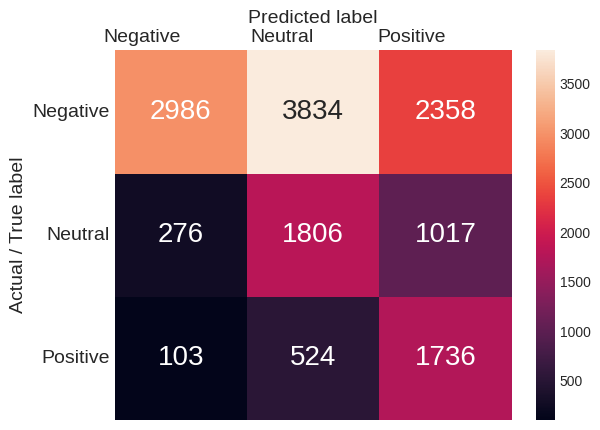

In [23]:
cfm = confusion_matrix(df['airline_sentiment'], df['textblob_prediction'])
df_confusion_matrix = pd.DataFrame(cfm, ('Negative', 'Neutral', 'Positive'), ('Negative', 'Neutral', 'Positive'))

heatmap = sns.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 20}, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')

plt.ylabel('Actual / True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

plt.show()

In [24]:
accuracy = accuracy_score(df['airline_sentiment'], df['textblob_prediction'])

print("Accuracy: {}\n".format(accuracy))

Accuracy: 0.4459016393442623



In [25]:
report = classification_report(df['airline_sentiment'], df['textblob_prediction'])
print(report)

              precision    recall  f1-score   support

    negative       0.89      0.33      0.48      9178
     neutral       0.29      0.58      0.39      3099
    positive       0.34      0.73      0.46      2363

    accuracy                           0.45     14640
   macro avg       0.51      0.55      0.44     14640
weighted avg       0.67      0.45      0.46     14640



### Insights

With an accuracy of 44.5% the prediction is worse than flipping a coin. More work on preparing the data could maybe be one way to improve the result.

## Sentiment prediction using various SKlearn models

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

In [27]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)

features = vectorizer.fit_transform(df['clean_text'])
labels = df['airline_sentiment'].values

In [28]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [29]:
def check_scores(clf, X_train, X_test, y_train, y_test):
  model = clf.fit(X_train, y_train)

  predicted_class = model.predict(X_test)
  predicted_class_train = model.predict(X_train)

  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]

  yhat = model.predict(X_test)

  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class))
  print()
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()



In [30]:
def grid_search(clf, parameters, X_train, Y_train):
  grid = GridSearchCV(estimator = clf, param_grid = parameters, cv = 4, verbose = 1) #, scoring='roc_auc')
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

### Decision Tree

In [31]:
# Create the parameter grid based on the results of random search
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [32]:
%%time
clf_best_model = grid_search(DecisionTreeClassifier(random_state=42), params, x_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


Best parameters are: 
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 20}
CPU times: user 31.3 s, sys: 54 ms, total: 31.3 s
Wall time: 31.6 s


In [33]:
check_scores(clf_best_model, x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[6593   57  188]
 [2025  177  159]
 [ 838   25  918]]

Test confusion matrix is: 
[[2245   23   72]
 [ 641   42   55]
 [ 273   10  299]]

              precision    recall  f1-score   support

    negative       0.71      0.96      0.82      2340
     neutral       0.56      0.06      0.10       738
    positive       0.70      0.51      0.59       582

    accuracy                           0.71      3660
   macro avg       0.66      0.51      0.50      3660
weighted avg       0.68      0.71      0.64      3660


Train accuracy score:  0.7001821493624772
Test accuracy score:  0.7065573770491803



## Naive Bayes

In [34]:
params = {
    'alpha': [0.01, 0.1, 1, 10]
}

In [35]:
%%time
clf_best_model = grid_search(MultinomialNB(), params, x_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


Best parameters are: 
{'alpha': 0.1}
CPU times: user 446 ms, sys: 1.08 ms, total: 447 ms
Wall time: 450 ms


In [36]:
check_scores(clf_best_model, x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[6758   64   16]
 [ 800 1489   72]
 [ 360   72 1349]]

Test confusion matrix is: 
[[2187  110   43]
 [ 404  282   52]
 [ 208   69  305]]

              precision    recall  f1-score   support

    negative       0.78      0.93      0.85      2340
     neutral       0.61      0.38      0.47       738
    positive       0.76      0.52      0.62       582

    accuracy                           0.76      3660
   macro avg       0.72      0.61      0.65      3660
weighted avg       0.74      0.76      0.74      3660


Train accuracy score:  0.8739526411657559
Test accuracy score:  0.7579234972677595



## K-Nearest Neighbors (KNN)

In [37]:
params = {
    'n_neighbors': [2, 3, 5, 10, 15, 20]
}

In [38]:
%%time
clf_best_model = grid_search(KNeighborsClassifier(), params, x_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


Best parameters are: 
{'n_neighbors': 2}
CPU times: user 2min, sys: 301 ms, total: 2min
Wall time: 1min 20s


In [39]:
check_scores(clf_best_model, x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[6830    8    0]
 [ 161 2189   11]
 [  38  199 1544]]

Test confusion matrix is: 
[[2267   62   11]
 [ 535  179   24]
 [ 404   66  112]]

              precision    recall  f1-score   support

    negative       0.71      0.97      0.82      2340
     neutral       0.58      0.24      0.34       738
    positive       0.76      0.19      0.31       582

    accuracy                           0.70      3660
   macro avg       0.68      0.47      0.49      3660
weighted avg       0.69      0.70      0.64      3660


Train accuracy score:  0.9620218579234973
Test accuracy score:  0.6989071038251367



## Random Forest

In [40]:
params = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

In [41]:
%%time
clf_forest = RandomForestClassifier()
clf_best_model = grid_search(clf_forest, params, x_train, y_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


Best parameters are: 
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
CPU times: user 6min 14s, sys: 1.06 s, total: 6min 15s
Wall time: 6min 17s


In [42]:
check_scores(clf_best_model, x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[6838    0    0]
 [2361    0    0]
 [1781    0    0]]

Test confusion matrix is: 
[[2340    0    0]
 [ 738    0    0]
 [ 582    0    0]]

              precision    recall  f1-score   support

    negative       0.64      1.00      0.78      2340
     neutral       0.00      0.00      0.00       738
    positive       0.00      0.00      0.00       582

    accuracy                           0.64      3660
   macro avg       0.21      0.33      0.26      3660
weighted avg       0.41      0.64      0.50      3660


Train accuracy score:  0.6227686703096539
Test accuracy score:  0.639344262295082



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
